In [104]:
import pickle
import re

import en_core_sci_lg
import matplotlib.pyplot as plt
import medspacy
import numpy as np
import pandas as pd
import spacy
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent
from sklearn.manifold import TSNE
from spacy import displacy

In [105]:
# data_path = r"D:\Documents\UT\SS2025\AI 395T AI in Healthcare\Assignments\mimic-iii-clinical-database-1.4"
# diagnoses_icd_df = pd.read_csv(f'{data_path}\DIAGNOSES_ICD.csv.gz')
# noteevents_df = pd.read_csv(f'{data_path}\\NOTEEVENTS.csv.gz', compression='gzip', low_memory=False)

In [106]:
# # pickle both dfs for fast loading
# with open('diagnoses_icd_df.pkl', 'wb') as f:
#     pickle.dump(diagnoses_icd_df, f)
# with open('noteevents_df.pkl', 'wb') as f:
#     pickle.dump(noteevents_df, f)

In [107]:
# load the pickled dfs
with open('diagnoses_icd_df.pkl', 'rb') as f:
    diagnoses_icd_df = pickle.load(f)
with open('noteevents_df.pkl', 'rb') as f:
    noteevents_df = pickle.load(f)

In [108]:
# Get all DMII patients
mask = diagnoses_icd_df['ICD9_CODE'].fillna('').str.startswith('250')
filtered_diagnoses = diagnoses_icd_df[mask]

# merge filtered diagnoses and noteevents on SUBJECT_ID and HADM_ID
merged_df = pd.merge(filtered_diagnoses, noteevents_df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
# filter out only discharge summaries
merged_df = merged_df[merged_df['CATEGORY'] == 'Discharge summary']

# Should be left with all discharge reports for DMII patients
merged_df.info()

del diagnoses_icd_df, noteevents_df


<class 'pandas.core.frame.DataFrame'>
Index: 17996 entries, 0 to 462653
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ROW_ID_x     17996 non-null  int64  
 1   SUBJECT_ID   17996 non-null  int64  
 2   HADM_ID      17996 non-null  int64  
 3   SEQ_NUM      17996 non-null  float64
 4   ICD9_CODE    17996 non-null  object 
 5   ROW_ID_y     17996 non-null  int64  
 6   CHARTDATE    17996 non-null  object 
 7   CHARTTIME    0 non-null      object 
 8   STORETIME    0 non-null      object 
 9   CATEGORY     17996 non-null  object 
 10  DESCRIPTION  17996 non-null  object 
 11  CGID         0 non-null      float64
 12  ISERROR      0 non-null      float64
 13  TEXT         17996 non-null  object 
dtypes: float64(3), int64(4), object(7)
memory usage: 2.1+ MB


In [109]:
# fetch n rows
n = 1
patient_df = merged_df[:n]

def normalize_text(text):
    # Lowercasing may not be needed as models are case sensitive
    # This strips only extra whitespace.
    text = re.sub(r'\s+', ' ', text).strip()
    return text

texts = merged_df['TEXT'].tolist()
# remove all special chars from texts
texts = [normalize_text(text) for text in texts]
del merged_df


In [110]:
def nlp_ize(nlp):
    docs = []
    for text in [texts[15708]]:
        docs.append(nlp(text))
        # for ent in docs[-1].ents:
        #     print(ent.text, ent.start_char, ent.end_char, ent.label_)
        # print("*********************************************************")
    return docs

def displacy_display(docs):
    for doc in docs:
        displacy.render(doc, style='ent', jupyter=True)
        # print("*********************************************************")

In [111]:
spacy_nlp = spacy.load('en_core_web_lg')
spacy_docs = nlp_ize(spacy_nlp)
displacy_display(spacy_docs)


In [112]:
scispacy_nlp = en_core_sci_lg.load()
scispacy_docs = nlp_ize(scispacy_nlp)
displacy_display(scispacy_docs)


In [113]:
# ----- DIABETES RULES -----
# A generic rule to catch any mention of diabetes, even if it's brief
diabetes_generic = TargetRule(
    "Diabetes", "PROBLEM",
    pattern=[
        {"LOWER": "type", "OP": "?"},
        {"LOWER": {"IN": ["2", "ii", "two"]}, "OP": "?"},
        {"LOWER": {"IN": ["diabetes", "dm"]}}
    ]
)

# A more specific rule for Type II Diabetes Mellitus
type_ii_diabetes = TargetRule(
    "Type II Diabetes Mellitus", "PROBLEM",
    pattern=[
        {"LOWER": "type"},
        {"LOWER": {"IN": ["2", "ii", "two"]}},
        {"LOWER": {"IN": ["diabetes", "dm"]}},
        {"LOWER": "mellitus", "OP": "?"}
    ]
)

# ----- DIABETIC COMPLICATIONS -----
# Diabetic Neuropathy
diabetic_neuropathy = TargetRule(
    "Diabetic Neuropathy", "PROBLEM",
    pattern=[
        {"LOWER": "diabetic"},
        {"LOWER": "neuropathy"}
    ]
)

# Diabetic Retinopathy
diabetic_retinopathy = TargetRule(
    "Diabetic Retinopathy", "PROBLEM",
    pattern=[
        {"LOWER": "diabetic"},
        {"LOWER": "retinopathy"}
    ]
)

# Diabetic Nephropathy
diabetic_nephropathy = TargetRule(
    "Diabetic Nephropathy", "PROBLEM",
    pattern=[
        {"LOWER": "diabetic"},
        {"LOWER": "nephropathy"}
    ]
)

# Diabetic Foot complications
diabetic_foot = TargetRule(
    "Diabetic Foot", "PROBLEM",
    pattern=[
        {"LOWER": "diabetic"},
        {"LOWER": "foot"}
    ]
)

# Common glycemic disturbances
hyperglycemia = TargetRule(
    "Hyperglycemia", "PROBLEM",
    pattern=[
        {"LOWER": "hyperglycemia"}
    ]
)

hypoglycemia = TargetRule(
    "Hypoglycemia", "PROBLEM",
    pattern=[
        {"LOWER": "hypoglycemia"}
    ]
)

# ----- MEDICATION RULES -----
# Metformin
metformin = TargetRule(
    "Metformin", "MEDICATION",
    pattern=[
        {"LOWER": "metformin"}
    ]
)

# Insulin (could be more specific if needed)
insulin = TargetRule(
    "Insulin", "MEDICATION",
    pattern=[
        {"LOWER": "insulin"}
    ]
)

# Glipizide, an example sulfonylurea
glipizide = TargetRule(
    "Glipizide", "MEDICATION",
    pattern=[
        {"LOWER": "glipizide"}
    ]
)

# Pioglitazone, another diabetes medication
pioglitazone = TargetRule(
    "Pioglitazone", "MEDICATION",
    pattern=[
        {"LOWER": "pioglitazone"}
    ]
)

# Combine all rules into a list for your matcher
target_rules = [
    diabetes_generic,   # captures even brief mentions of "diabetes"
    type_ii_diabetes,   # more specific to Type II if available
    diabetic_neuropathy,
    diabetic_retinopathy,
    diabetic_nephropathy,
    diabetic_foot,
    hyperglycemia,
    hypoglycemia,
    metformin,
    insulin,
    glipizide,
    pioglitazone
]

In [114]:
medspacy_nlp = medspacy.load()

# Add rules for target concept extraction
target_matcher = medspacy_nlp.get_pipe("medspacy_target_matcher")
target_matcher.add(target_rules)

medspacy_docs = []
for text in [texts[15708]]:
    docs = medspacy_nlp(text)
    medspacy_docs.append(medspacy_nlp(text))
# 220

visualize_ent(medspacy_docs[0])
# displacy_display(medspacy_docs)


In [115]:
from gensim.models import word2vec

# create corpus for each ent
def create_corpus(docs):
    corpus = []
    for doc in docs:
        str_tokens = []
        for ent in doc.ents:
            str_tokens.append(ent.text)
        corpus.append(list(str_tokens))
    return corpus

spacy_corpus = create_corpus(spacy_docs)
scispacy_corpus = create_corpus(scispacy_docs)
medspacy_corpus = create_corpus(medspacy_docs)

# create w2v encoding for each corpus
def w2v_encoding(corpus):
    model = word2vec.Word2Vec(corpus, min_count=1)
    return model

spacy_model = w2v_encoding(spacy_corpus)
scispacy_model = w2v_encoding(scispacy_corpus)
medspacy_model = w2v_encoding(medspacy_corpus)

In [116]:
# find shared words between the 3 models
# Calculate shared words using gensim 4.0.0 .key_to_index attribute
shared_words = set(spacy_model.wv.key_to_index.keys()) & \
               set(scispacy_model.wv.key_to_index.keys()) & \
               set(medspacy_model.wv.key_to_index.keys())

print(shared_words)

{'Metformin'}


In [117]:
word="Metformin"
# print(spacy_model.wv[word])
print(spacy_model.wv.similar_by_word(word))
print("**********")
# print(scispacy_model.wv[word])
print(scispacy_model.wv.similar_by_word(word))
print("**********")
# print(medspacy_model.wv[word])
print(medspacy_model.wv.similar_by_word(word))


[('8', 0.3672943711280823), ('Ths', 0.3229667842388153), ('10mg qd', 0.2742091119289398), ('10', 0.2729567289352417), ('Adhesive Patch', 0.2604641616344452), ('25 mg', 0.25716981291770935), ('2 %', 0.2536088824272156), ('12 %', 0.2426413744688034), ('MICU', 0.24118733406066895), ('Elavil', 0.23834893107414246)]
**********
[('admission', 0.28744882345199585), ('Physical Exam', 0.27554622292518616), ('course', 0.2651689946651459), ('residual left sided weakness', 0.2642539143562317), ('Amitriptyline 75 mg', 0.26013752818107605), ('Blood cultures', 0.2519819736480713), ('ASA 325 mg', 0.2425287365913391), ('Plt Ct-499* [**2150', 0.23777084052562714), ('Diazepam 10 mg', 0.23755508661270142), ('elevated', 0.22633618116378784)]
**********
[('diabetic neuropathy', 0.13912132382392883), ('metformin', 0.13191209733486176), ('diabetes', 0.06445958465337753), ('DIABETES', 0.06059185788035393), ('DM', 0.01943519525229931), ('Insulin', 0.00972563587129116), ('Type 2 Diabetes Mellitus', -0.0574917607

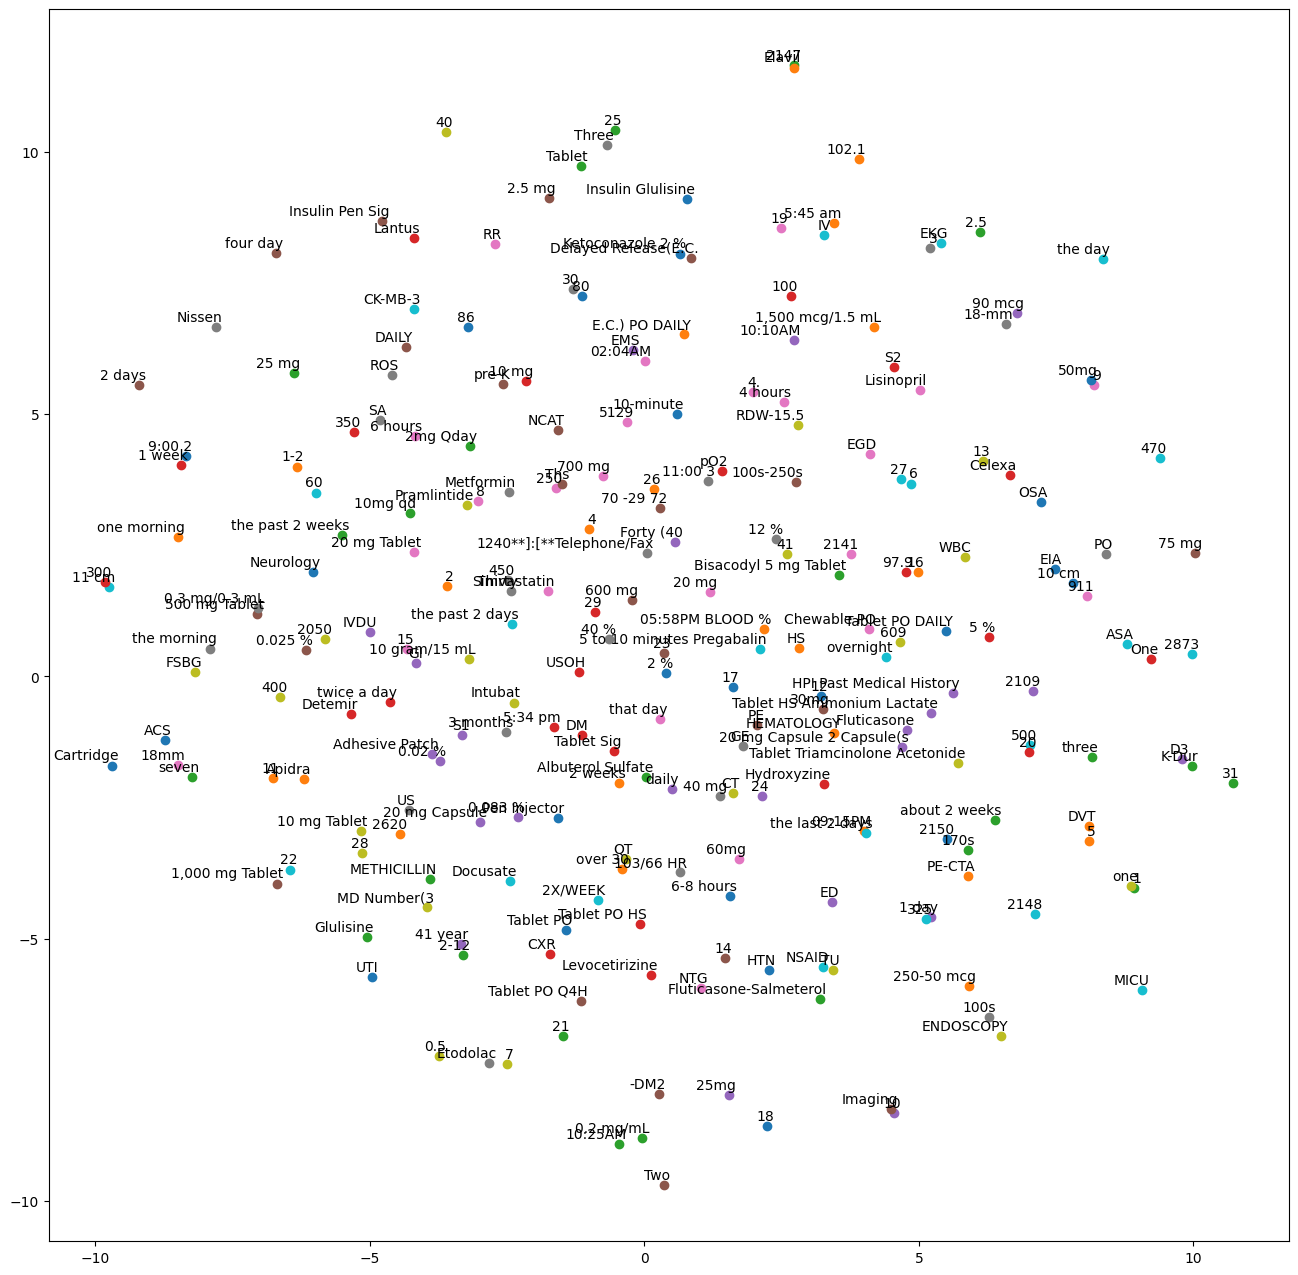

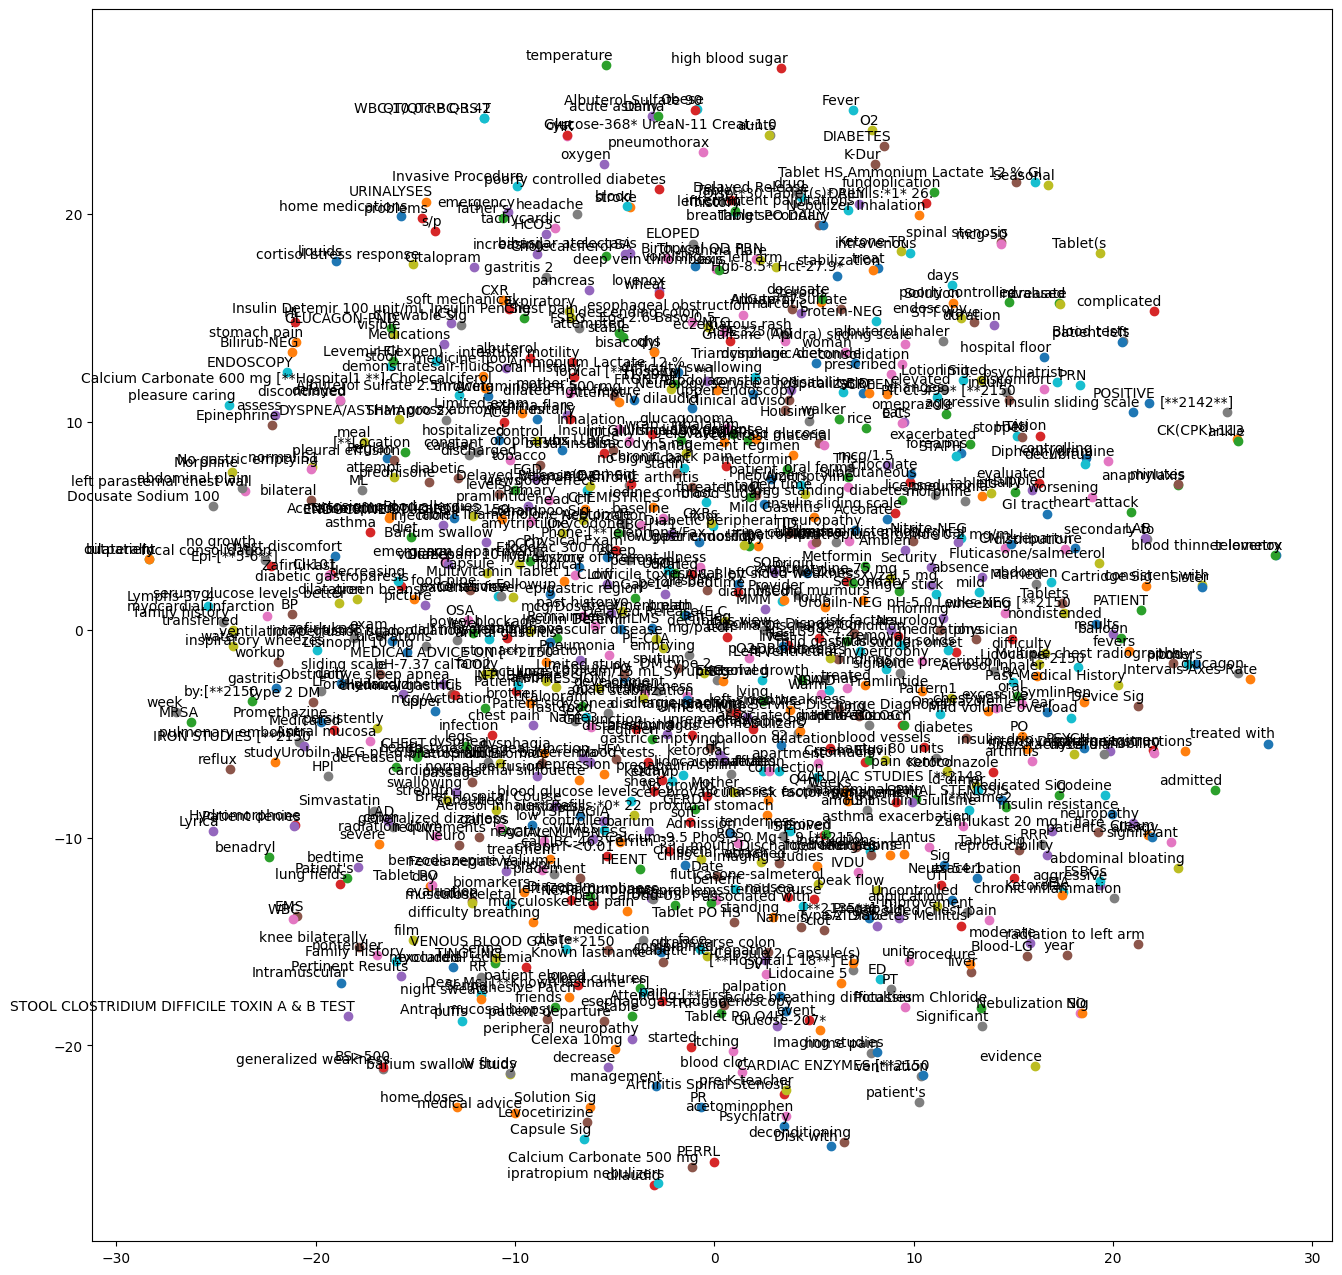

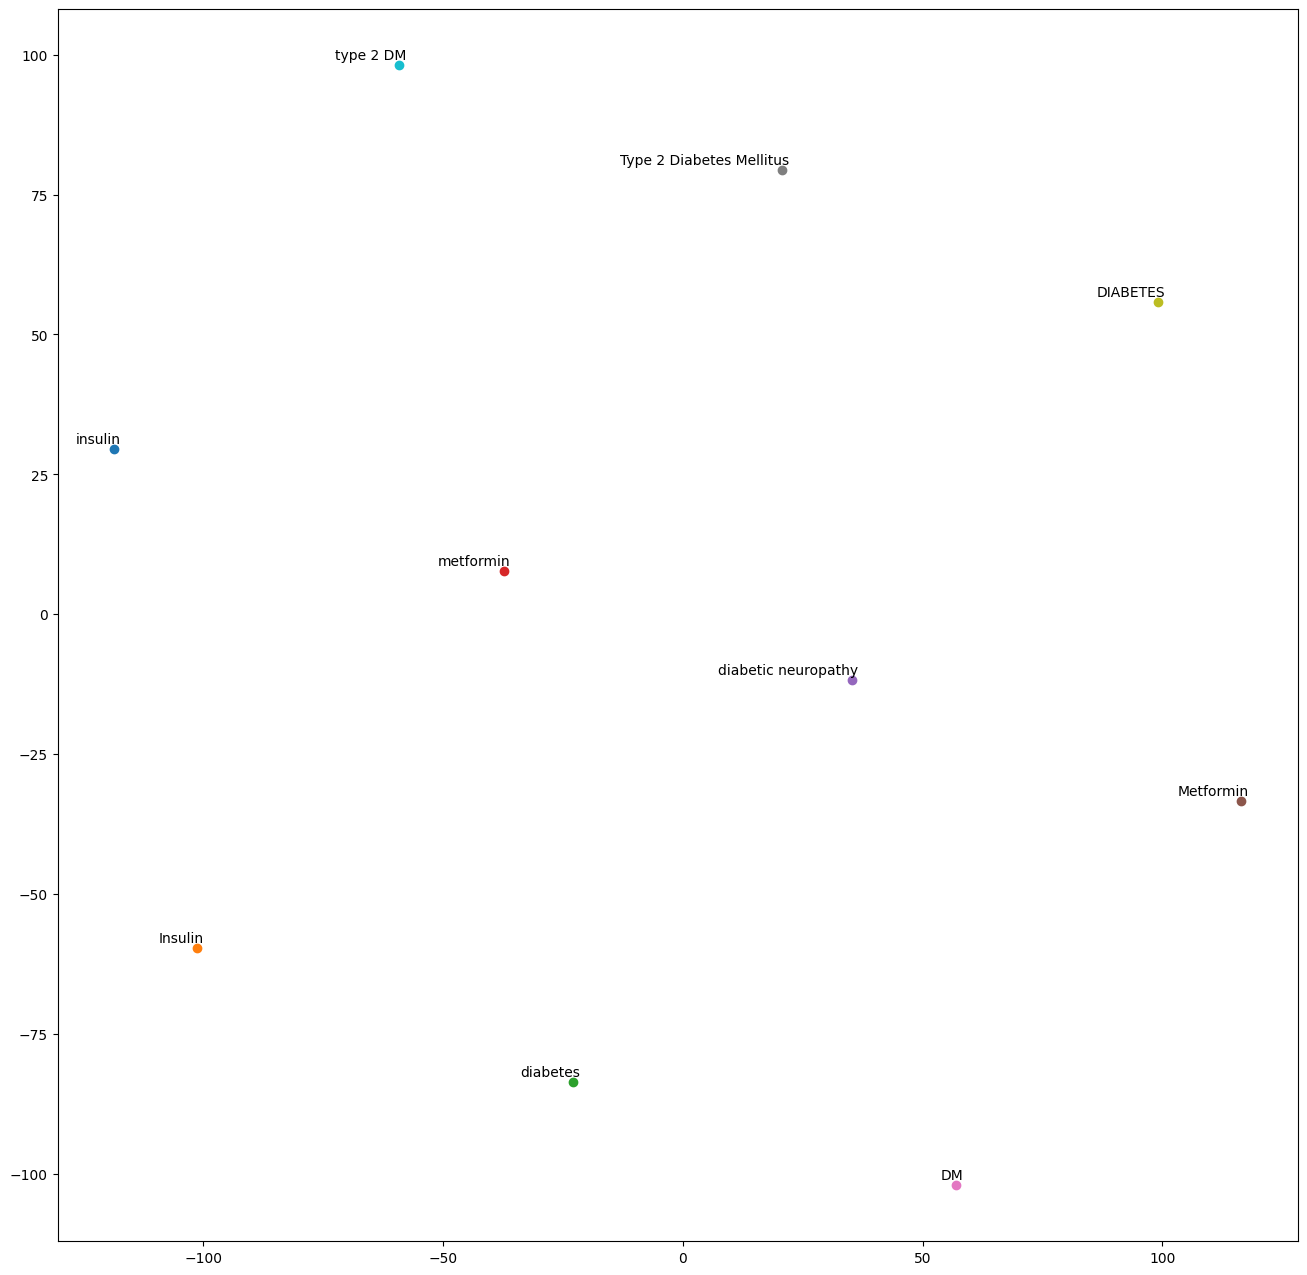

In [118]:
# create function to plot t-SNE
def tsne_plot(model):
    words = np.array(list(model.wv.key_to_index.keys()))
    "Creates a t-SNE model and plots it"
    labels = []
    tokens = []

    for word in words:
        if word in model.wv.key_to_index:
            tokens.append(model.wv[word])
            labels.append(word)
        else:
            print(f"Skipping \\`{word}\\` as it is not in the model's vocabulary.")

    tokens = np.array(tokens)

    tsne_model = TSNE(perplexity=min(30, words.shape[0] - 1), early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# plot t-SNE for shared words
# Define your list of words for visualization (arbitrary selection)
tsne_plot(spacy_model)
tsne_plot(scispacy_model)
tsne_plot(medspacy_model)